In [1]:
# import requests
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

from toolz.curried import pipe, map, filter, reduce, memoize

In [2]:
requests = cloudscraper.create_scraper(browser={'browser': 'firefox','platform': 'windows','mobile': False})

In [3]:
BASE_URL = 'https://www.theswiftcodes.com/'

## Base Page → Countries

In [4]:
@memoize
def get_countries(base_url):
    
    res = requests.get(base_url)
    base_page = BeautifulSoup(res.text, 'html.parser')

    return [(opt.text, f"{base_url}/{opt.text.lower().strip().replace(' ', '-')}") 
            for opt in base_page.find_all('option')]

In [5]:
# get_countries(BASE_URL)

## Countries → Paginated Countries

#### Helper function

In [6]:
def count_pages(page: BeautifulSoup) -> int:
    
    # find the "LAST" span, and parse its URL
    last_tag_list = list(filter(
        lambda tag: "last" in tag.text.lower(),
        page.find("div", {"class": "navigation navigation--top"}).find_all('span')
    ))
    
    if not last_tag_list:
        return 1

    else:
        last_tag = last_tag_list[0] if last_tag_list else None
        page_count = last_tag.find('a')['href'].strip('/').split('/')[-1]
        
        return int(page_count)

In [7]:
@memoize
def get_paginated_country(country: str, country_url: str) -> tuple:
    """If a country is paginated, add all paginated urls."""
    
    res = requests.get(country_url)
    page = BeautifulSoup(res.text, 'html.parser')
    
    # get page_count
    page_count = count_pages(page)
    
    # NOTE: when generating this, since the upper-bound of range is EXCLUDED, increment page_count so that we INCLUDE it.
    country_urls_list = [f'{country_url}/page/{n}' if n > 1 else country_url for n in range(1, page_count+1)]
    
    return country, tuple(country_urls_list)

In [8]:
# [get_paginated_country(*x) for x in get_countries(BASE_URL)]

## Country Page -> Bank Swift DF

In [9]:
def get_swift_codes_df(country_name: str, url: str) -> pd.DataFrame:
    res = requests.get(url)
    page = BeautifulSoup(res.text, 'html.parser')

    try:
        raw_data = [tag.text 
                    for tag in page.find_all("table", {"class": "swift-country"})[0].find_all('td') 
                    if tag.text != '\n']
    except Exception as e:
        print(f"failed on ", country_name)
        print(page.find_all("table", {"class": "swift-country"}))
        
        raise e

    np_data = np.array(raw_data)
    reshaped_data = np_data.reshape((int(len(np_data)/5), 5))

    df = pd.DataFrame(
        reshaped_data, 
        columns=['No', 'Institution', 'City', 'Branch', 'Swift Code']
    )

    df['Country'] = country_name
    df = df[['Country', 'Institution', 'City', 'Branch', 'Swift Code']]
    
    print(country_name)
    
    return df

#### Helper function

In [10]:
def swift_code_runner(country_name: str, urls: list) -> list:

    return pd.concat(
        map(
            lambda url: get_swift_codes_df(country_name, url),
            urls
        )
    )

In [11]:
%%time
df_list = pipe(
    # base_url -> country urls
    get_countries(BASE_URL),
    
    # country url -> paginated country urls
    map(
        lambda tup: get_paginated_country(*tup)
    ),
    
    # paginated country urls -> DFs
    map(
        lambda tup: swift_code_runner(*tup)
    ),

    list
)

ALBANIA
ALGERIA
ALGERIA
ALGERIA
ALGERIA
AMERICAN SAMOA
ANDORRA
ANGOLA
ANGUILLA
ANTIGUA AND BARBUDA
ARGENTINA
ARGENTINA
ARMENIA
ARUBA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRALIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AUSTRIA
AZERBAIJAN
BAHAMAS
BAHAMAS
BAHRAIN
BAHRAIN
BAHRAIN
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BANGLADESH
BARBADOS
BELARUS
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELGIUM
BELIZE
BENIN
BERMUDA
BHUTAN
BOLIVIA
BONAIRE
BOSNIA AND HERZEGOVINA
BOTSWANA
BRAZIL
BRAZIL
BRAZIL
BRAZIL
BRAZIL
BRAZIL
BRUNEI
BULGARIA
BURKINA FASO
CAMBODIA
CAMBODIA
CAMEROON
CANADA
CANADA
CANADA
CANADA
CANADA
CANADA
CANADA
CAPE VERDE
CAYMAN ISLANDS
CAYMA

In [12]:
# swift_code_runner(*('JAMAICA', ('https://www.theswiftcodes.com//jamaica',)))

In [13]:
final_df = pd.concat(df_list)

## Write to CSV

In [22]:
final_df.to_csv('swift_codes_david_final.csv', index=False)

#### Examine the Data

In [21]:
final_df.sample(10)

Country                                        Institution  \
48        INDIA                                STATE BANK OF INDIA   
14      CROATIA                       INTERCAPITAL SECURITIES LTD.   
5        GUYANA            GUYANA BANK FOR TRADE AND INDUSTRY LTD.   
3       VIETNAM  VIETNAM BANK FOR AGRICULTURE AND RURAL DEVELOP...   
27        CHINA                              CHINA EVERBRIGHT BANK   
26  NETHERLANDS  NEDERLANDS CENTRAAL INSTITUUT VOOR GIRAAL EFFE...   
46        INDIA                                BANK OF MAHARASHTRA   
44        ITALY             BANCA MONTE DEI PASCHI DI SIENA S.P.A.   
23        CHINA              THE BANK OF EAST ASIA (CHINA) LIMITED   
7         ITALY  BANCA CARIGE SPA - CASSA DI RISPARMIO DI GENOV...   

                  City                              Branch   Swift Code  
48  THIRUVANANTHAPURAM                        (NRI BRANCH)  SBININBB131  
14              ZAGREB                                         INUIHR22  
5           GEORGETOWN                       (MAIN BRANCH)     GUTIGYGE  
3            SOC TRANG                   (SOCTRANG BRANCH)  VBAAVNVX790  
27             QINGDAO                    (QINGDAO BRANCH)  EVERCNBJQD1  
26           AMSTERDAM                                      ESESNL2A777  
46             PANIPAT                           (PANIPAT)  MAHBINBBPAN  
44       PORTO AZZURRO                                      PASCITMMPOA  
23           CHONGQING                  (CHONGQING BRANCH)  BEASCNSHCQN  
7               GENOVA  (BRANCH NO 51 - OSPEDALE GALLIERA)  CRGEITGG099

<AxesSubplot:>

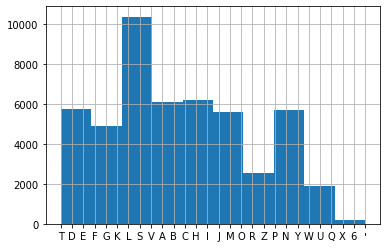

In [16]:
final_df['City'].str[0].hist()

In [17]:
final_df.shape

(49258, 5)